In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
)

We begin by importing all necessary modules for our analysis. As for our other methods, we define our three policies here too.

In [4]:
#importing packages
from ema_workbench import (
 Policy,
 ema_logging,
 MultiprocessingEvaluator,
 ScalarOutcome
)

import problem_formulation
from importlib import reload

reload(problem_formulation)  # this is used to reload the problem formulation.py so the changes made there are registered.
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(3)

import copy

#Here we print the uncertainties, levers and outcomes, to check them
for unc in dike_model.uncertainties:
 print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)
for policy in dike_model.levers:
 print(repr(policy))

levers = copy.deepcopy(dike_model.levers)
for outcome in dike_model.outcomes:
 print(repr(outcome))


def get_do_nothing_dict():
 return {l.name: 0 for l in dike_model.levers}


#Here the policies for the start analysis are defined
policies = [
 Policy(
  "policy 1",  #nothing policy
  **dict(
   get_do_nothing_dict(),
  )
 ),
 Policy(
  "policy 2",  # dike increase policy
  **dict(
   get_do_nothing_dict(),
   **{"A.1_DikeIncrease 0": 5, "A.2_DikeIncrease 0": 5, "A.3_DikeIncrease 0": 5, "A.4_DikeIncrease 0": 5}
  )
 ),
 Policy(
  "policy 3",  #dike increase and room for the river policy
  **dict(
   get_do_nothing_dict(),
   **{"1_RfR 1": 1, "2_RfR 1": 1, "3_RfR 1": 1, "5_RfR 1": 1, "A.1_DikeIncrease 0": 5, "A.2_DikeIncrease 0": 5,
      "A.3_DikeIncrease 0": 5, "A.4_DikeIncrease 0": 5}
  )
 ),
]

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

Once the preliminary steps complete, we can set up Sobol using the SAlib library. We run our model once again, this time adding an uncertainty sampling method. Once the model is ran, we can set up Sobol for our two outcomes of interests: Deaths and Total Costs for dike ring 5.

In [5]:
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
# pass the policies list to EMA workbench experiment runs #`1`
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies,  uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = results
problem = get_SALib_problem(dike_model.uncertainties)
Si_Deaths = sobol.analyze(problem, outcomes['A.5_Expected Number of Deaths'], calc_second_order=True, print_to_console=False)
Si_Costs = sobol.analyze(problem, outcomes['A.5 Total Costs'], calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started with 16 workers
C:\Users\tangu\PycharmProjects\MBDB\.venv\lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 40000 scenarios * 3 policies * 1 model(s) = 120000 experiments
100%|████████████████████████████████| 120000/120000 [1:33:50<00:00, 21.31it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
C:\Users\tangu\PycharmProjects\MBDB\.venv\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


We can finally plot our sensitivity analysis, first for deaths, then for costs.

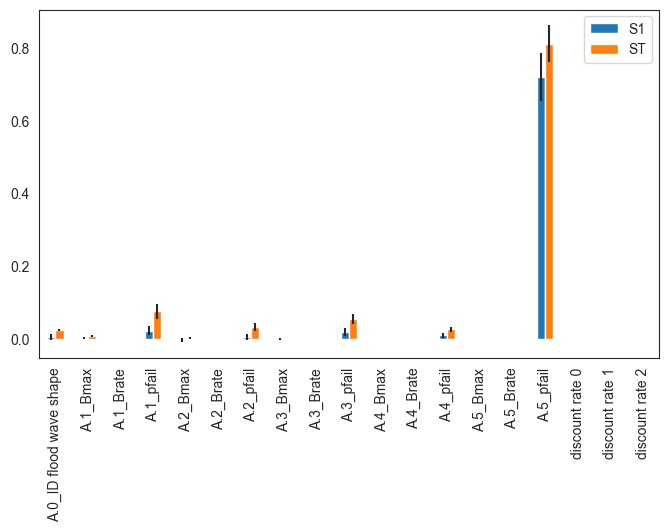

In [6]:
scores_filtered = {k: Si_Deaths[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [8]:
Si_df.to_csv('Si_Deaths.csv')

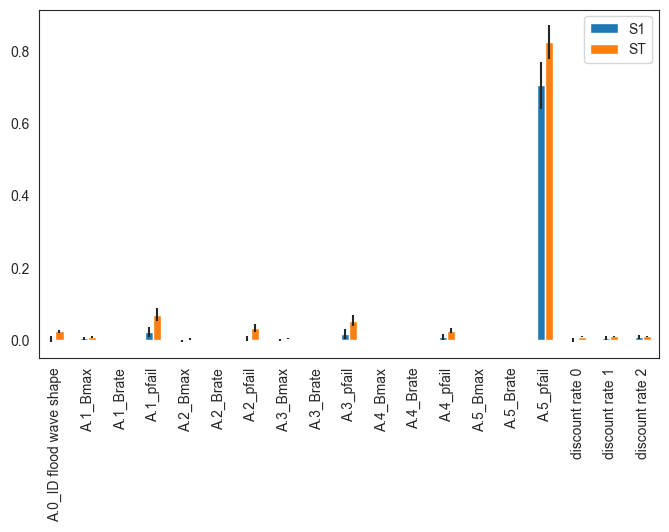

In [7]:
scores_filtered = {k: Si_Costs[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()